In [1]:
spark

In [83]:
#!pip install wordcloud
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.sql import types
from pyspark.sql.functions import unix_timestamp, from_unixtime
%matplotlib inline
import json
import pandas as pd
import numpy as np

from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [3]:
spark = SparkSession.builder.appName('TwitterCovid19').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

In [4]:
df = spark.read.option("multiline","true").option("header", "true").option("ignoreTrailingWhiteSpace","true").option("ignoreLeadingWhiteSpace", "true").option("inferSchema", "true").csv("gs://bigdata_project_hksv/tweetData/*.csv")

In [5]:
df.select('tweet_id').count()

147974250

In [6]:
df.show(20)

+-------------------+----------+--------+-----+--------------+----------+--------------------+
|           tweet_id|     tdate|   ttime|tlang|tcountry_place|month_year|               tweet|
+-------------------+----------+--------+-----+--------------+----------+--------------------+
|1313520869407371264|2020-10-06|16:45:53|   en|          NULL|   2020-10|Trump looked like...|
|1313520870183243777|2020-10-06|16:45:54|   en|          NULL|   2020-10|Secret Service Ag...|
|1313520870216916994|2020-10-06|16:45:54|   en|          NULL|   2020-10|                null|
|1313520870472781826|2020-10-06|16:45:54|   en|          NULL|   2020-10|                null|
|1313520870988681216|2020-10-06|16:45:54|   en|          NULL|   2020-10|                null|
|1313520872301363201|2020-10-06|16:45:54|   en|          NULL|   2020-10|Local experts fro...|
|1313520872691503106|2020-10-06|16:45:54|   en|          NULL|   2020-10|#NYC to test #tea...|
|1313520873048084481|2020-10-06|16:45:54|   en|   

In [7]:
df.printSchema()

root
 |-- tweet_id: string (nullable = true)
 |-- tdate: string (nullable = true)
 |-- ttime: string (nullable = true)
 |-- tlang: string (nullable = true)
 |-- tcountry_place: string (nullable = true)
 |-- month_year: string (nullable = true)
 |-- tweet: string (nullable = true)



In [8]:
df1 = df.dropna(thresh=1, subset=('tweet'))
df1 = df1.filter(df1.tlang == "en")

In [9]:
df1.show()

+-------------------+----------+--------+-----+--------------+----------+--------------------+
|           tweet_id|     tdate|   ttime|tlang|tcountry_place|month_year|               tweet|
+-------------------+----------+--------+-----+--------------+----------+--------------------+
|1313520869407371264|2020-10-06|16:45:53|   en|          NULL|   2020-10|Trump looked like...|
|1313520870183243777|2020-10-06|16:45:54|   en|          NULL|   2020-10|Secret Service Ag...|
|1313520872301363201|2020-10-06|16:45:54|   en|          NULL|   2020-10|Local experts fro...|
|1313520872691503106|2020-10-06|16:45:54|   en|          NULL|   2020-10|#NYC to test #tea...|
|1313520873048084481|2020-10-06|16:45:54|   en|          NULL|   2020-10|Lewis &amp; Bunti...|
|1313520873228431360|2020-10-06|16:45:54|   en|          NULL|   2020-10|Not out of the wo...|
|1313520873656274946|2020-10-06|16:45:54|   en|          NULL|   2020-10|Media has been ab...|
|1313520874604158976|2020-10-06|16:45:55|   en|   

In [11]:
df1.select('tweet').count()

115533149

In [31]:
df_count= df1.groupBy("tcountry_place").count().sort('count').orderBy(['count'], ascending=False)

In [14]:
df_count.show()

+--------------+-----+
|tcountry_place|count|
+--------------+-----+
|            DZ|  217|
|            MM|  599|
|            LT|  219|
|            CI|  277|
|            FI| 2290|
|            AZ|  195|
|            UA|  541|
|            ZM| 2998|
|            RO|  671|
|            SL|  697|
|            NL| 9948|
|            SB|   78|
|            LA|  110|
|            BW| 3432|
|            BS| 2052|
|            TC|   86|
|            MN|  202|
|            SC|   80|
|            KI|    5|
|            PM|    1|
+--------------+-----+
only showing top 20 rows



In [15]:
df1.groupBy("tlang").count().show()

+-----+---------+
|tlang|    count|
+-----+---------+
|   en|115533149|
+-----+---------+



In [16]:
df1.describe().show()

+-------+--------------------+----------+---------+---------+--------------+----------+--------------------+
|summary|            tweet_id|     tdate|    ttime|    tlang|tcountry_place|month_year|               tweet|
+-------+--------------------+----------+---------+---------+--------------+----------+--------------------+
|  count|           115533149| 115533149|115533149|115533149|     115526085| 115533149|           115533149|
|   mean|1.294652085970361...|      null|     null|     null|          null|      null|                null|
| stddev|4.142943127424581...|      null|     null|     null|          null|      null|                null|
|    min| 1213330173736738817|2020-01-04| 00:00:00|       en|            AD|   2020-01| https://t.co/4um...|
|    max| 1388272692785082372|2021-04-30| 23:59:59|       en|            \N|   2021-04|􏰃@AZCourts @doug...|
+-------+--------------------+----------+---------+---------+--------------+----------+--------------------+



In [17]:
df1.select('tcountry_place').distinct().count()

242

In [18]:
df1.select('month_year').distinct().count()

16

In [10]:
df2 = df1.withColumn('tweet1',regexp_replace(col('tweet'), '@', ''))
df2 = df2.withColumn('tweet2',regexp_replace(col('tweet1'), '#', ''))
df2 = df2.withColumn('tweet2',regexp_replace(col('tweet2'), 'RT', ''))
df2 = df2.withColumn('tweet2',regexp_replace(col('tweet2'), ':', ''))
df2 = df2.withColumn('tweet2',regexp_replace(col('tweet2'), 'http\S+', ''))
df2.select(col('tweet2')).show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tweet2                                                                                                                                                                                                                                                                                           |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Trump looked like a man trying to contain his disdain. He should've felt great after the ending scene, Mission Accomplished

In [32]:
pdf_con = df_count.toPandas()

In [33]:
pdf_con.head()

,tcountry_place,count
0,NULL,112265362
1,US,1629549
2,GB,472196
3,IN,241066
4,CA,181953


In [40]:
pdf_con = pdf_con[pdf_con['tcountry_place'] != "NULL"]

In [41]:
pdf_con.head()

,tcountry_place,count
1,US,1629549
2,GB,472196
3,IN,241066
4,CA,181953
5,NG,84665


In [48]:
dfRange = pdf_con.iloc[0:15]

[Text(0.5, 1.0, 'Top 15 User Locations')]

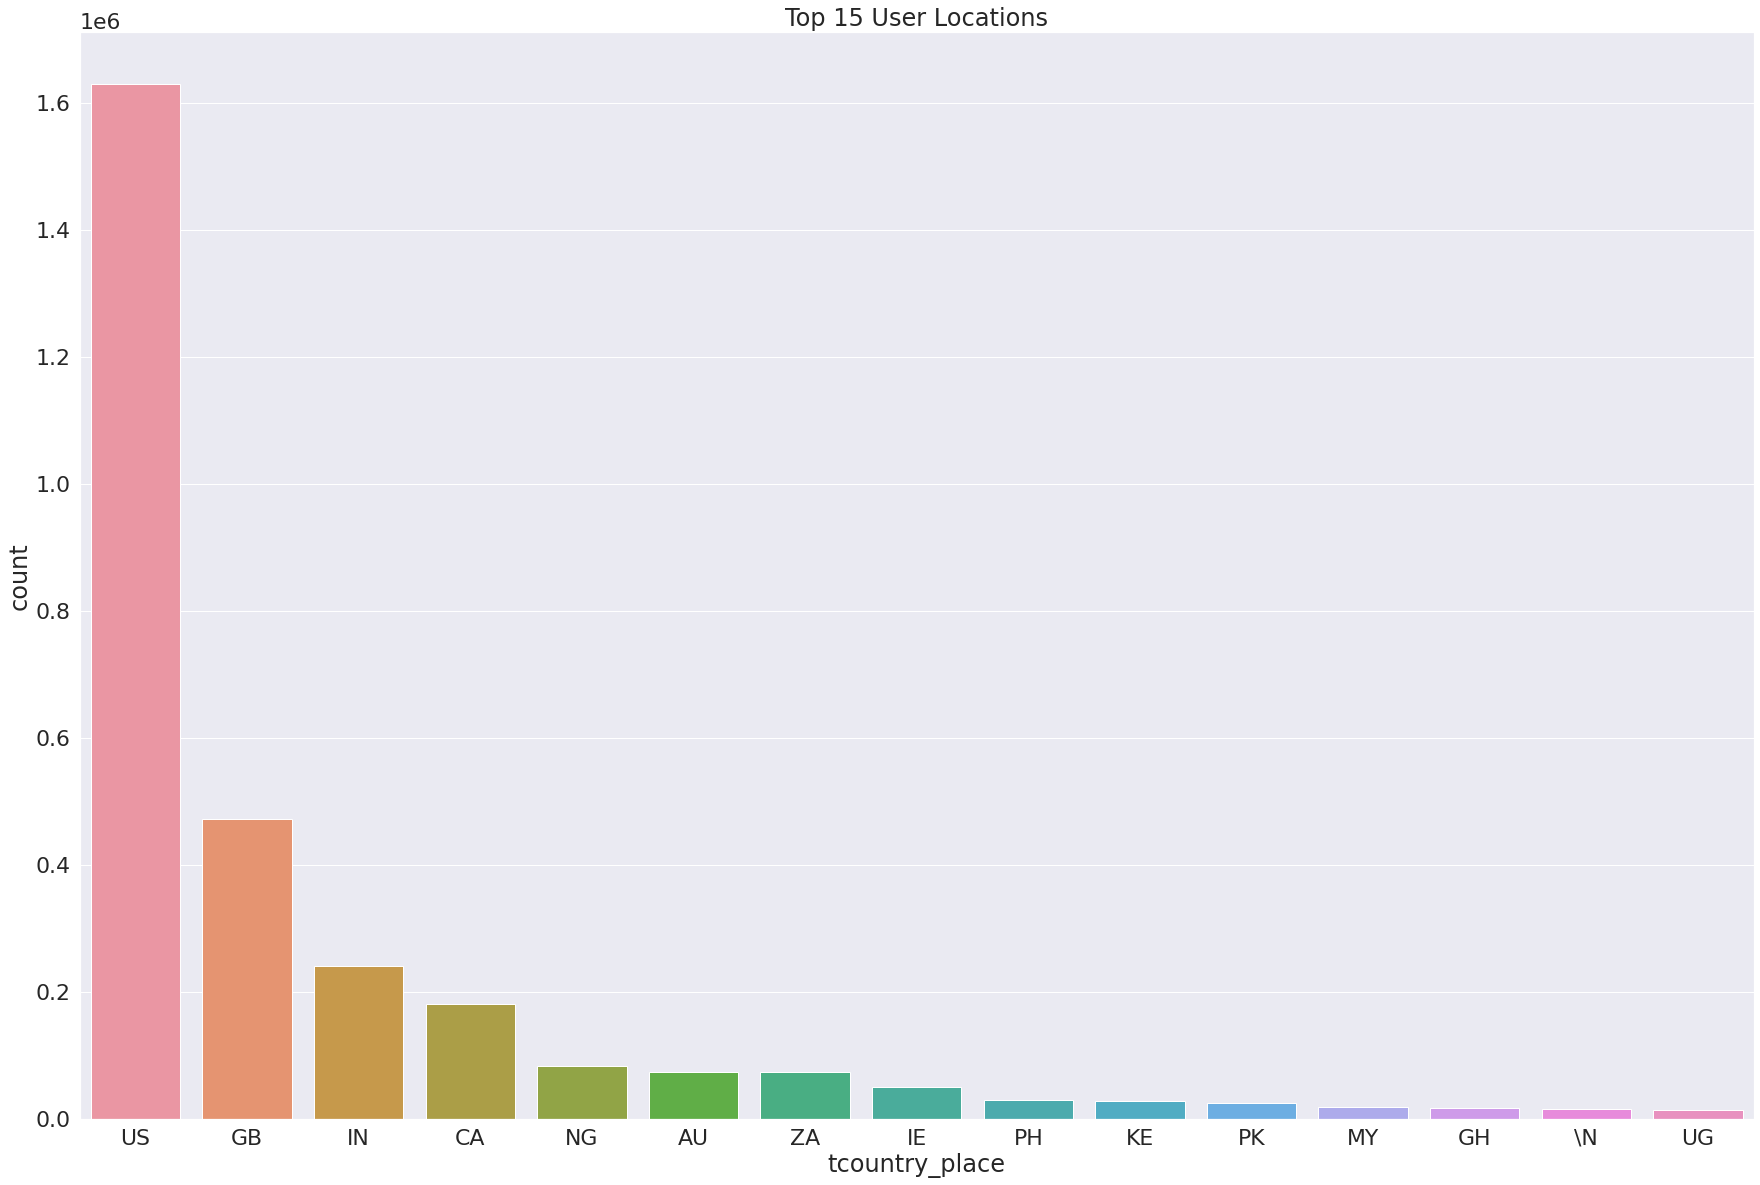

In [98]:
fig = plt.figure(figsize = (30, 20))
sns.set(font_scale = 2)
sns.barplot(x = 'tcountry_place', y = 'count', data= dfRange).set(title='Top 15 User Locations')

In [52]:
dfRange_wous = pdf_con.iloc[1:16]

[Text(0.5, 1.0, 'Top 15 User Locations without US')]

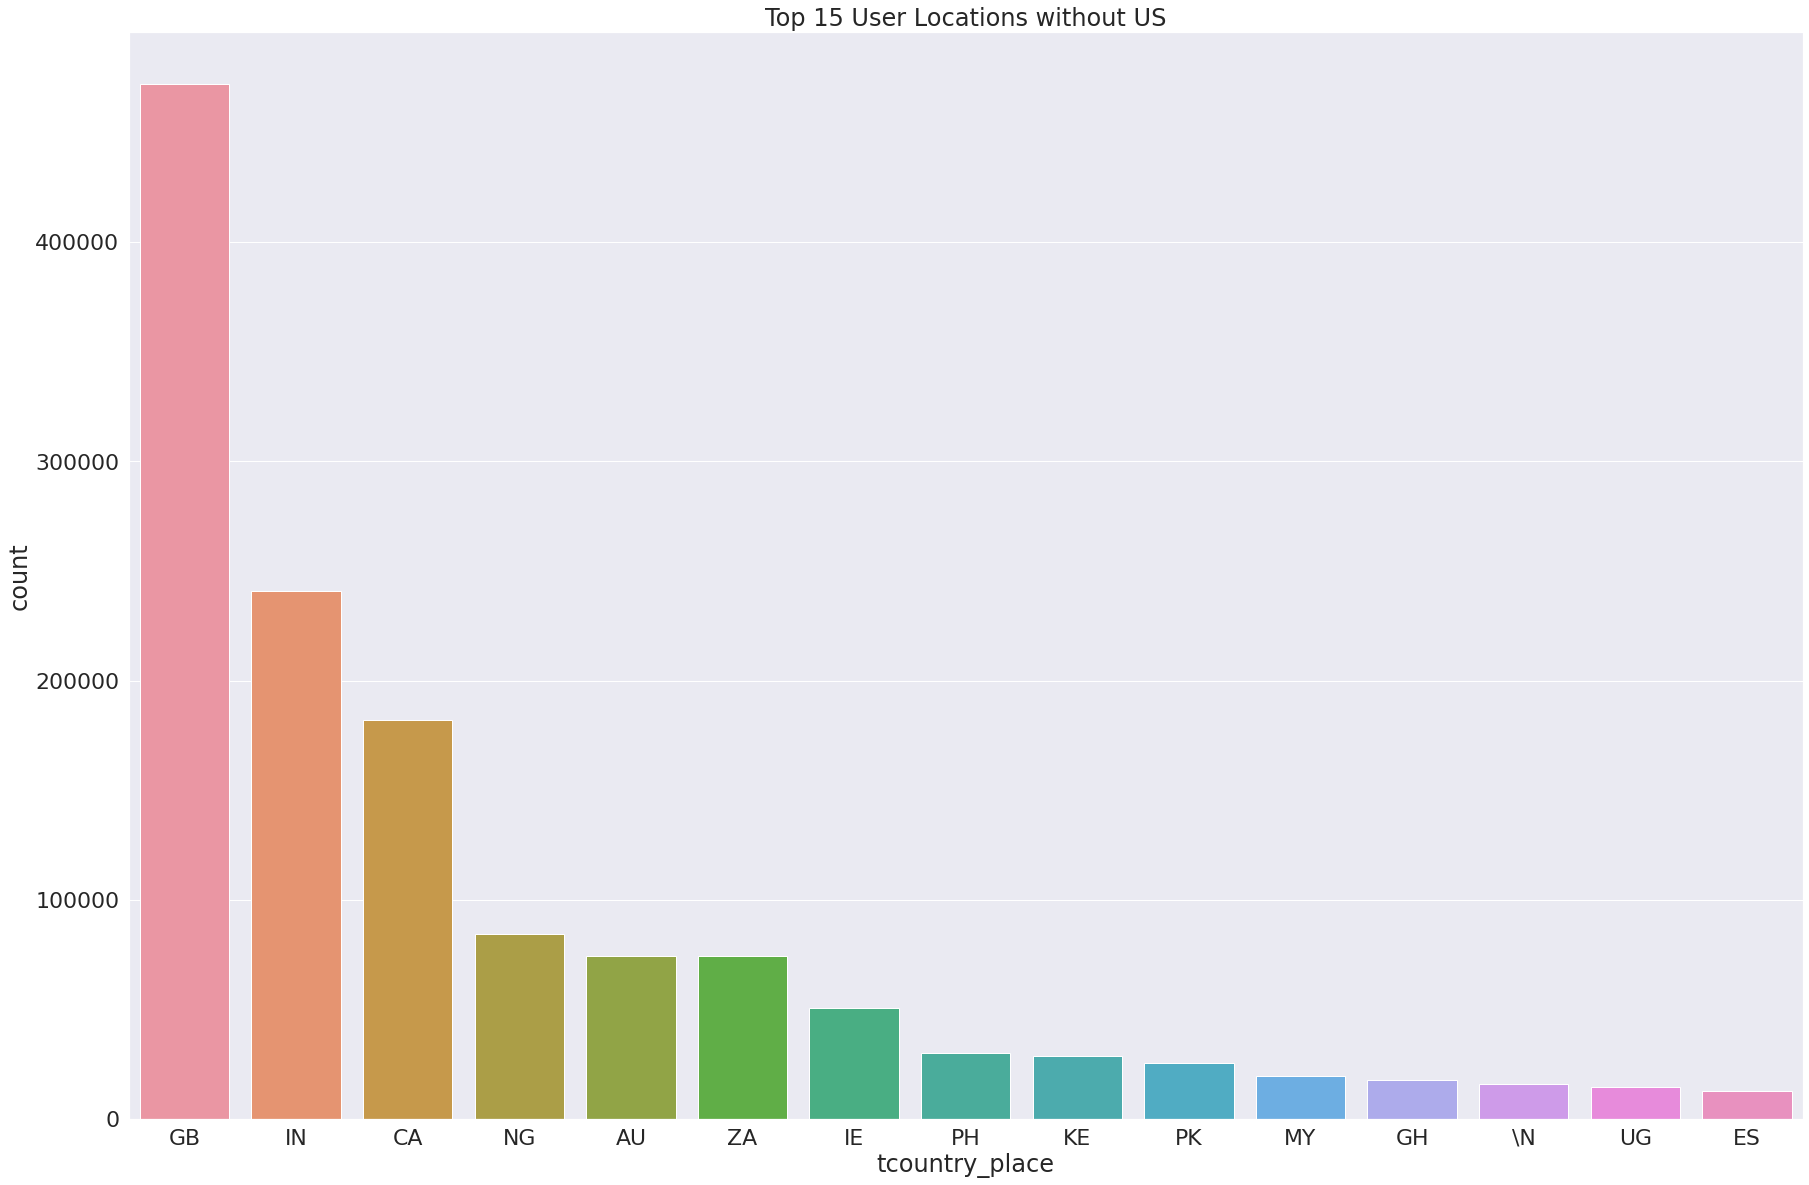

In [99]:
fig = plt.figure(figsize = (30, 20))
sns.set(font_scale = 2)
sns.barplot(x = 'tcountry_place', y = 'count', data= dfRange_wous).set(title='Top 15 User Locations without US')

In [15]:
pdf = pd.read_csv("gs://bigdata_project_hksv/tweetData/*.csv")

In [18]:
pdf = pdf.dropna(thresh=1, subset=['tweet'])

In [20]:
pdf = pdf[pdf['tlang']== 'en']

In [77]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(30,30))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

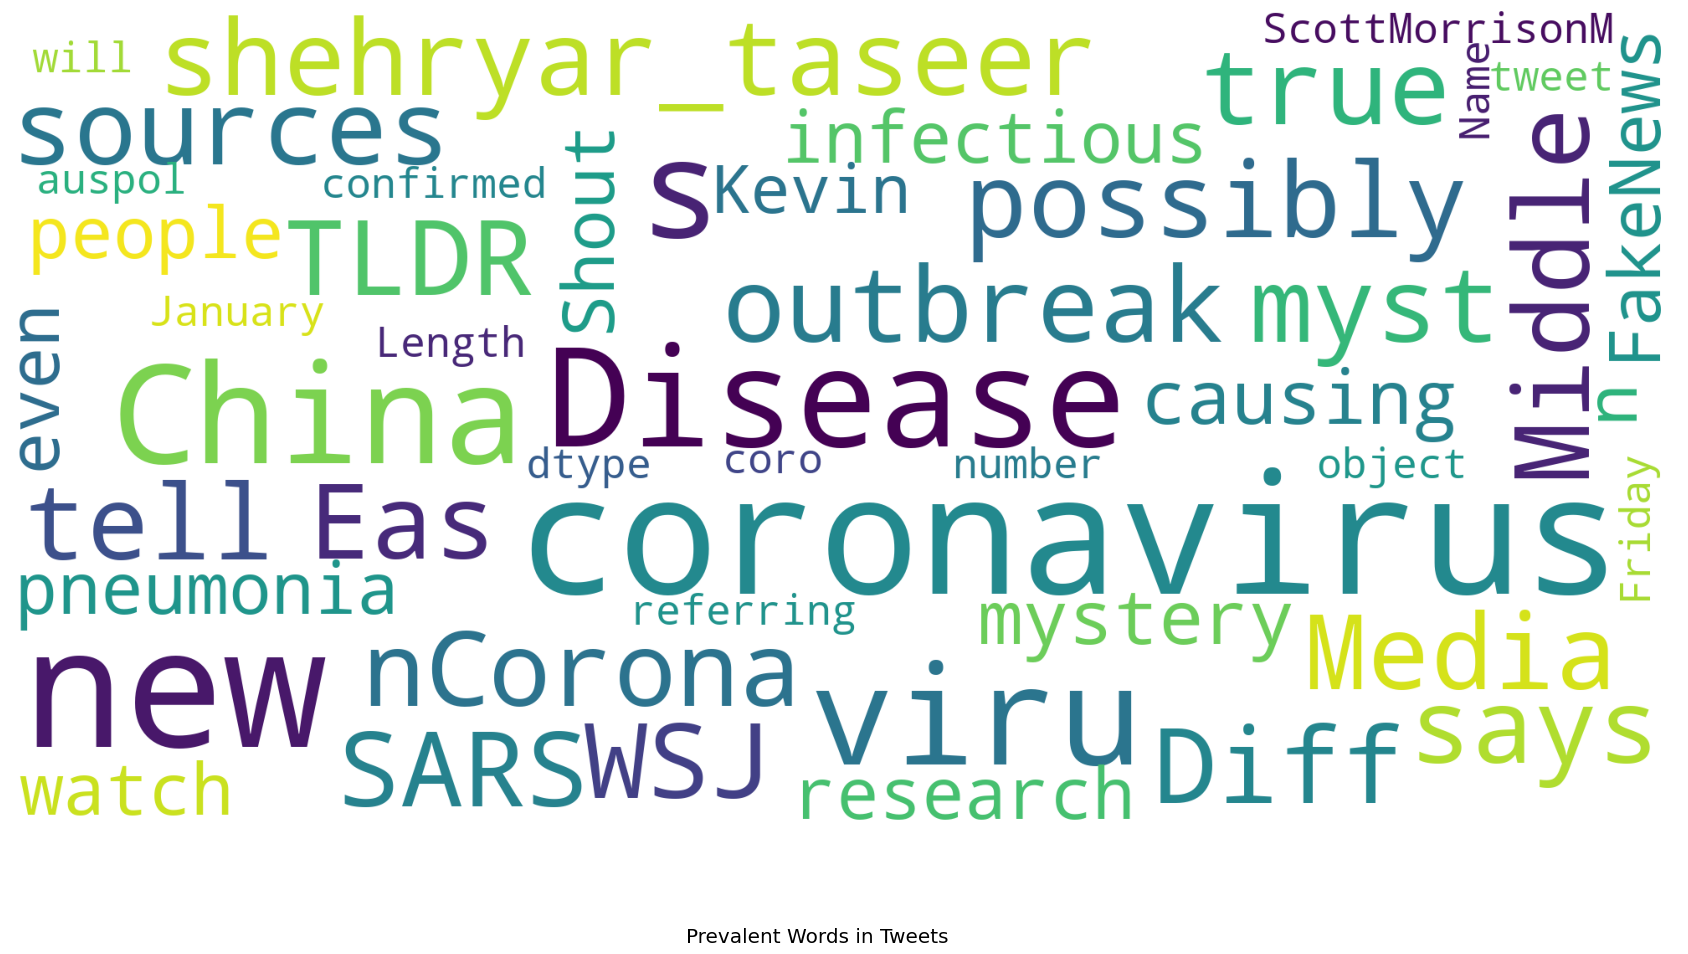

In [78]:
show_wordcloud(pdf['tweet'], title = 'Prevalent Words in Tweets')

In [63]:
df4 = df2.groupby('month_year').count().sort('count').orderBy(['month_year'], ascending = False)

In [64]:
df4.show(5)

+----------+-------+
|month_year|  count|
+----------+-------+
|   2021-04|2970010|
|   2021-03|4472621|
|   2021-02|4091941|
|   2021-01|5918941|
|   2020-12|7248214|
+----------+-------+
only showing top 5 rows



In [65]:
pdf_month = df4.toPandas()

In [79]:
pdf_month = pdf_month.sort_values(by='month_year')

In [80]:
pdf_month.head()

,month_year,count
15,2020-01,501587
14,2020-02,2290113
13,2020-03,8849133
12,2020-04,13164216
11,2020-05,13377750


[Text(0.5, 1.0, 'Number of Tweets by Month')]

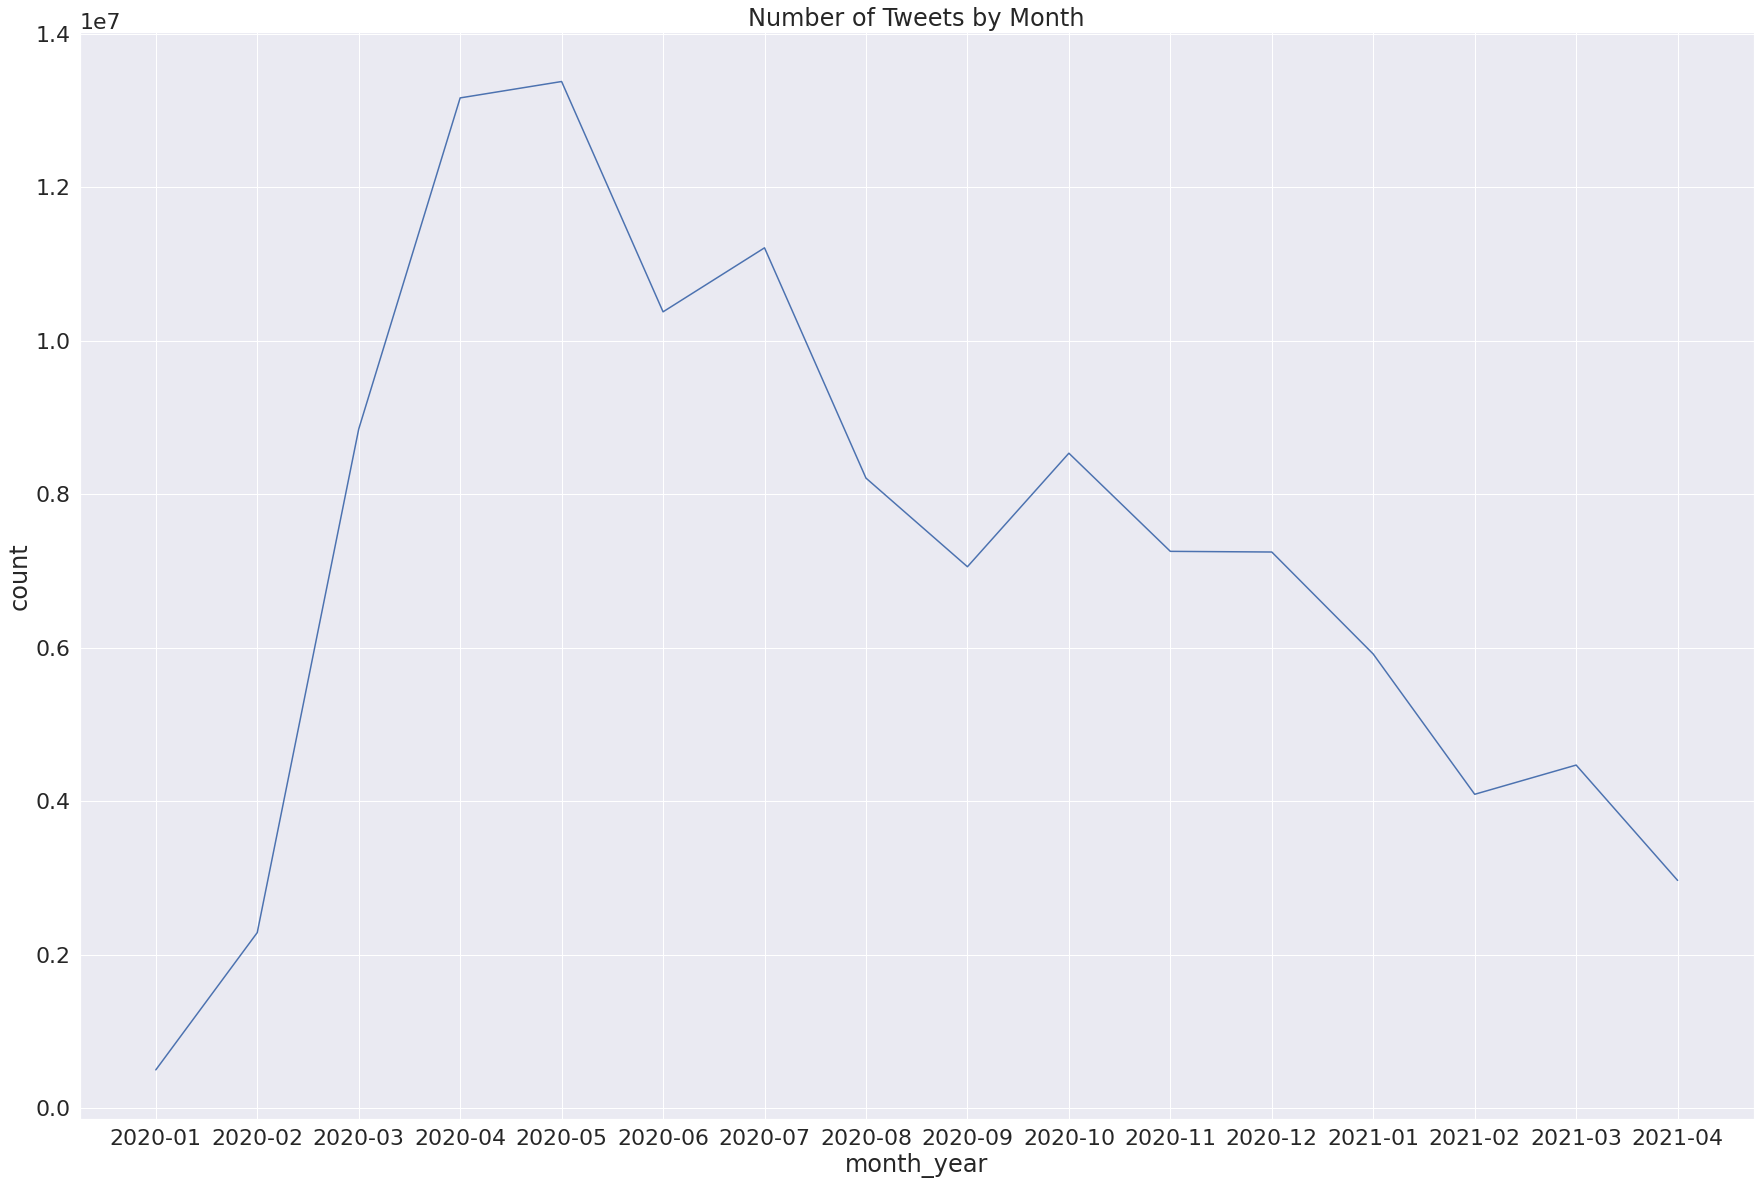

In [100]:
fig = plt.figure(figsize = (30, 20))
sns.set(font_scale = 2)
sns.lineplot(x = 'month_year', y = 'count', data= pdf_month).set(title='Number of Tweets by Month')

In [94]:
df5 = df2.withColumn('ttime', df2['ttime'].substr(0, 2))

In [95]:
df6 = df5.select('ttime').groupby('ttime').count().sort('count').orderBy(['ttime'], ascending = False)

In [96]:
df6.show()

+-----+-------+
|ttime|  count|
+-----+-------+
|   23|4610800|
|   22|4971322|
|   21|5240469|
|   20|5482798|
|   19|5652199|
|   18|5886122|
|   17|6111992|
|   16|6273267|
|   15|6161035|
|   14|6096603|
|   13|5789147|
|   12|5337937|
|   11|4752677|
|   10|4168913|
|   09|4070407|
|   08|4111738|
|   07|4165872|
|   06|3544083|
|   05|3440481|
|   04|3557167|
+-----+-------+
only showing top 20 rows



In [97]:
pdf_hour = df6.toPandas()

[Text(0.5, 1.0, 'Number of Tweets by Hour')]

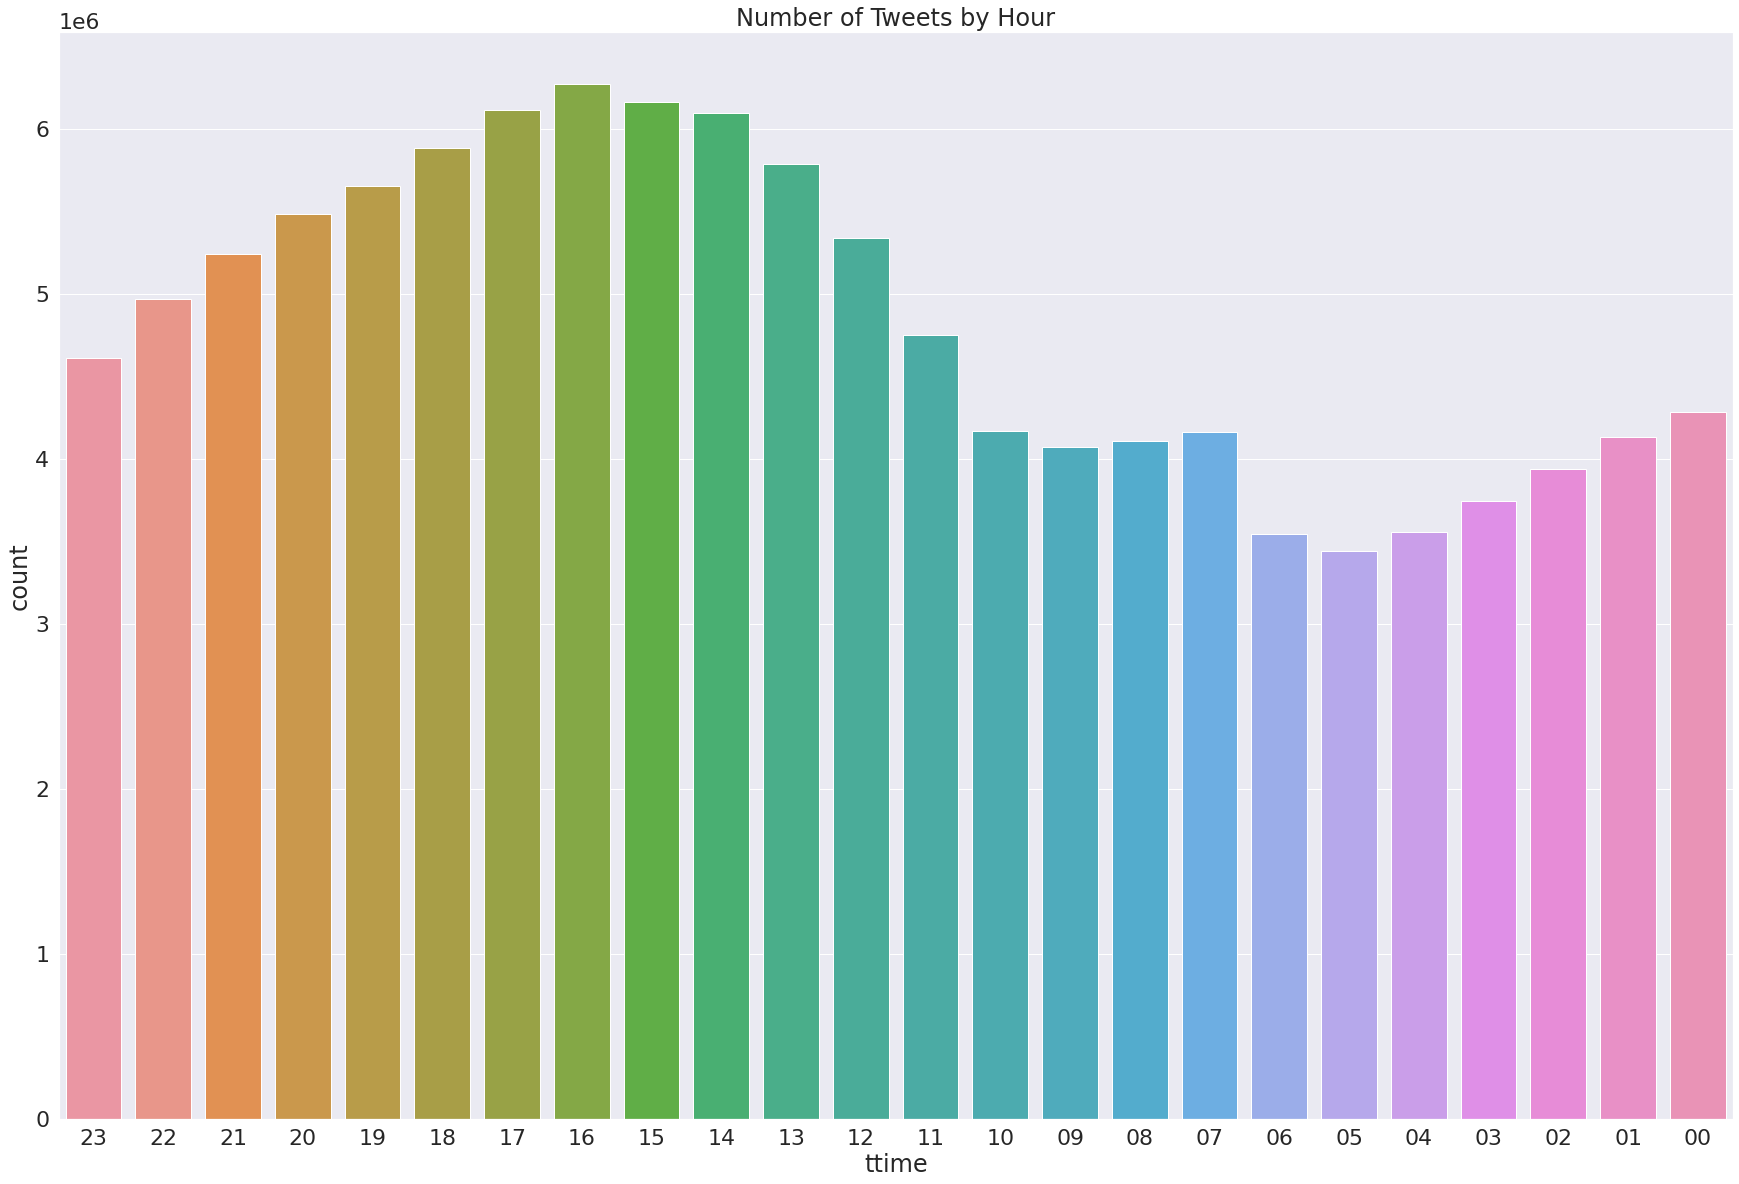

In [103]:
fig = plt.figure(figsize = (30, 20))
sns.set(font_scale = 2)
sns.barplot(x = 'ttime', y = 'count', data= pdf_hour).set(title='Number of Tweets by Hour')